In [1]:
device = "TPU-VM" #or "GPU"

In [2]:
if device=='TPU-VM':
    !pip install -q seaborn
#     !pip install -q sklearn
#     !pip install -q scikit-learn --upgrade
#     !pip install -q mlxtend
    
    
    # # FOR TPU VM
#     !pip install -q /lib/wheels/tensorflow-2.9.1-cp38-cp38-linux_x86_64.whl
#     !pip install -q tensorflow-addons==0.18.0
#     !pip install -q tensorflow-probability==0.17.0
#     !pip install -q opencv-python-headless
#     !pip install -q seaborn
    
    # Custom Libraries
    # !pip install -q keras-cv-attention-models
    # !pip install -qU wandb
    # !pip install -qU scikit-learn

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [3]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# import Deep learning Libraries
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_effnet
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.imagenet_utils import preprocess_input 

from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')
print('Running TF: ', tf.__version__)

D0924 03:11:23.245045631      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0924 03:11:23.245068137      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0924 03:11:23.245071748      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0924 03:11:23.245074631      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0924 03:11:23.245077246      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0924 03:11:23.245080075      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0924 03:11:23.245082709      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0924 03:11:23.

modules loaded
Running TF:  2.12.0


In [4]:
!pip install -q efficientnet
!pip install -q image-classifiers

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [5]:
import efficientnet.tfkeras as efn
from classification_models.keras import Classifiers
seresnext101, preprocess_senet = Classifiers.get('seresnext101')

In [6]:
if "TPU" in device:
    tpu = 'local' if device=='TPU-VM' else None
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
    except:
        device = "GPU"
        
if device == "GPU"  or device=="CPU":
    ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
    if ngpu>1:
        print("Using multi GPU")
        strategy = tf.distribute.MirroredStrategy()
    elif ngpu==1:
        print("Using single GPU")
        strategy = tf.distribute.get_strategy()
    else:
        print("Using CPU")
        strategy = tf.distribute.get_strategy()
        device = "CPU"

if device == "GPU":
    print("Num GPUs Available: ", ngpu)
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/tas

# Data Loading

In [7]:
def augment(img, label):
    # Random horizontal flip
    img = tf.image.random_flip_left_right(img)
    
    # Random rotation
    img = tf.image.rot90(img, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    # Random zoom
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(224, 224))
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    img = tf.cond(choice < 0.5, lambda: img, lambda: random_crop(img))
    
    return img, label

In [8]:
import random

def decode_image(filename, label, image_size=(224, 224)):
    img = tf.io.read_file(filename)
    img = tf.image.decode_bmp(img, channels=3)
    img = tf.image.resize(img, image_size, method='bicubic')
    img = tf.cast(img, tf.float32)
    img = tf.reshape(img, [224, 224, 3]) 
    return img, label

def load_ds(data_folder, shuffle=False):
    # Get the list of all the images
    classes = ['hem', 'all']  # Replace with your classes
    files_labels = []
    for i, cls in enumerate(classes):
        files = tf.io.gfile.glob(str(data_folder) + cls + '/*.bmp')
        labels = [i]*len(files)  # Create labels
        files_labels += list(zip(files, labels))
        print(len(files), len(labels), data_folder, cls)

    # Shuffle files and labels together if required
    if shuffle:
        random.shuffle(files_labels)

    filenames = [item[0] for item in files_labels]
    labels = [item[1] for item in files_labels]
    
    # Create dataset
    ds = tf.data.Dataset.from_tensor_slices((filenames, labels))
    ds = ds.map(decode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return ds

def get_datasets(train_folder, valid_folder, test_folder):
    train_ds = load_ds(train_folder)
    valid_ds = load_ds(valid_folder, shuffle=True)  # Shuffle validation data once
    test_ds = load_ds(test_folder)
    
    # Shuffle the training data
    BUFFER_SIZE = 30000  # use a buffer size the same as or larger than the full dataset size for full shuffling
    train_ds = train_ds.shuffle(BUFFER_SIZE)
    
    # Apply augmentation only to the training data
    train_ds = train_ds.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # You can add batch, prefetch, and shuffle here as needed
    train_ds = train_ds.batch(64, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
    valid_ds = valid_ds.batch(64, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
    test_ds = test_ds.batch(64, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
    
    return train_ds, valid_ds, test_ds  


In [9]:
# Load datasets
train_ds, valid_ds, test_ds = get_datasets('/kaggle/input/leuk-isbi-zero/train/', '/kaggle/input/leuk-augs-zero/val/', '/kaggle/input/leuk-augs-zero/test/')

2372 2372 /kaggle/input/leuk-isbi-zero/train/ hem
5090 5090 /kaggle/input/leuk-isbi-zero/train/ all
508 508 /kaggle/input/leuk-augs-zero/val/ hem
1090 1090 /kaggle/input/leuk-augs-zero/val/ all
509 509 /kaggle/input/leuk-augs-zero/test/ hem
1092 1092 /kaggle/input/leuk-augs-zero/test/ all


# Model Building

In [10]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as prepro_func
import tensorflow_addons as tfa

In [11]:
def Ranger():
    radam = tfa.optimizers.RectifiedAdam()
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    return ranger

In [12]:
import sys
sys.path.append('../input/swintransformertf')
from swintransformer import SwinTransformer

In [13]:
with strategy.scope():
#     base_model = tf.keras.applications.efficientnet_v2.ConvNeXtLarge(include_top= False, weights= "imagenet", input_shape= (224, 224, 3))
#     # base_model = seresnext101(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

#     # preprocess = tf.keras.layers.Lambda(lambda data: tf.keras.applications.imagenet_utils.preprocess_input(data, mode="torch"))
#     inp = tf.keras.layers.Input(shape=(224,224,3))

#     # x = preprocess(inp)
#     x = base_model(inp)
#     # x = cbam_block(x)
#     x = GlobalMaxPooling2D()(x)
# #     x = BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001)(x)
# #     x = Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), 
# #               activity_regularizer= regularizers.l1(0.006), 
# #               bias_regularizer= regularizers.l1(0.006), activation= 'relu')(x)
# #     x = Dropout(rate= 0.45, seed= 123)(x)
#     out = Dense(1, activation= 'sigmoid')(x)

#     model = tf.keras.Model(inp, out)

#     # model = Sequential([
#     #     tf.keras.layers.Lambda(lambda data: tf.keras.applications.imagenet_utils.preprocess_input(data, mode="torch")),
#     #     base_model,
#     #     cbam_block,
#     #     BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
#     #     Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
#     #                 bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
#     #     Dropout(rate= 0.45, seed= 123),
#     #     Dense(2, activation= 'softmax')
#     # ])

#     # model.build(input_shape=(None, 224, 224, 3))

#     model_url = "https://tfhub.dev/google/bit/m-r101x3/1" 
#     hub_module = hub.KerasLayer(model_url, trainable=True)

#     Teacher Model One
    base_teacher_one = tf.keras.applications.convnext.ConvNeXtBase(include_top= False, weights= "imagenet", input_shape= (224, 224, 3), pooling= 'max')
    
    teacher_one = Sequential([
        base_teacher_one,
        BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
        Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                    bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
#         Dense(256, activation= 'relu', kernel_regularizer= regularizers.l1()),
        Dropout(rate= 0.35, seed= 123),
        Dense(1)
    ])
    
    teacher_one.load_weights('/kaggle/input/leuk-teachers-cvnxtb-efv2m-logits/best_model_weights_convnext_base.h5')
    print('Loaded Teacher One')
    
    
#     Teacher Model Two
#     base_teacher_two = tf.keras.applications.efficientnet_v2.EfficientNetV2M(include_top= False, weights= "imagenet", input_shape= (224, 224, 3), pooling= 'max')

#     teacher_two = Sequential([
#         base_teacher_two,
#         BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
#         Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
#                     bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
# #         Dense(256, activation= 'relu', kernel_regularizer= regularizers.l1()),
#         Dropout(rate= 0.35, seed= 123),
#         Dense(1)
#     ])  
#     teacher_two.load_weights('/kaggle/input/leuk-teachers-cvnxtb-efv2m-logits/best_model_weights_efv2m.h5')
    
    img_adjust_layer = tf.keras.layers.Lambda(lambda data: tf.keras.applications.imagenet_utils.preprocess_input(tf.cast(data, tf.float32), mode="torch"), input_shape=[224, 224, 3])
    pretrained_model = SwinTransformer('swin_base_224', include_top=False, pretrained=True, use_tpu=False)
    
    teacher_two = Sequential([
        img_adjust_layer,
        pretrained_model,
        BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
        Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                    bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
#         Dense(256, activation= 'relu', kernel_regularizer= regularizers.l1()),
        Dropout(rate= 0.35, seed= 123),
        Dense(1)
    ])
    teacher_two.load_weights('/kaggle/input/leuk-kd-newml-teacher-vit-tn/best_model_weights.h5')
    
    print('Loaded Teacher Two')
    
#     Student Model
    base_student = tf.keras.applications.MobileNetV2(include_top= False, weights= "imagenet", input_shape= (224, 224, 3), pooling= 'max')
    
    student = Sequential([
        tf.keras.layers.Lambda(lambda data: tf.keras.applications.mobilenet_v2.preprocess_input(data)),
        base_student,
        BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
        Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                    bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
#         Dense(256, activation= 'relu', kernel_regularizer= regularizers.l1()),
        Dropout(rate= 0.35, seed= 123),
        Dense(1)
    ])

    student.build(input_shape=(None, 224, 224, 3))
    student.compile(optimizer=Adam(), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics= [tf.keras.metrics.BinaryAccuracy()])
    print('Built Student')
    
#     model.compile(optimizer=Ranger(), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics= [tf.keras.metrics.BinaryAccuracy()])

350926856/350926856 [==============================] - 2s 0us/step
Loaded Teacher One
321524991/321524991 [==============================] - 2s 0us/step
Loaded Teacher Two
9406464/9406464 [==============================] - 0s 0us/step
Built Student


In [14]:
teacher_one.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 1024)              87566464  
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 87,833,217
Trainable params: 87,831,169
Non-trainable params: 2,048
________________________________________

In [15]:
teacher_two.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 swin_base_224 (SwinTransfor  (None, 1024)             87079364  
 merModel)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dropout_74 (Dropout)        (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [16]:
student.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 batch_normalization_2 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dropout_75 (Dropout)        (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

### KD

In [17]:
class GatingNetwork(keras.Model):
    def __init__(self, num_teachers):
        super(GatingNetwork, self).__init__()
        self.conv1 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')
        self.maxpool1 = layers.MaxPooling2D(pool_size=(2, 2))
        self.conv2 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')
        self.maxpool2 = layers.MaxPooling2D(pool_size=(2, 2))
        self.gap = layers.GlobalAveragePooling2D()
        self.dense1 = layers.Dense(32, activation='relu')
        self.dense2 = layers.Dense(num_teachers, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.gap(x)
        x = self.dense1(x)
        return self.dense2(x)


In [18]:
class Distiller(keras.Model):
    def __init__(self, student, teachers, gating_network):
        super(Distiller, self).__init__()
        self.student = student
        self.teachers = teachers
        self.gating_network = gating_network

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha=0.1):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        
    def train_step(self, data):
        # Unpack the data
        x, y = data

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_logits = self.student(x, training=True)

            # Compute the student predictions for the distillation loss
            student_predictions = tf.nn.sigmoid(student_logits)
            
            # Compute student loss
            student_loss = self.student_loss_fn(y, student_predictions)

            # Forward pass of each teacher
            teacher_logits = [teacher(x, training=False) for teacher in self.teachers]
            teacher_predictions = [tf.nn.sigmoid(logits) for logits in teacher_logits]

            # Forward pass of gating network
            gating_weights = self.gating_network(x)

            # Compute the combined teacher predictions
            combined_teacher_predictions = 0
            for i, teacher_prediction in enumerate(teacher_predictions):
                combined_teacher_predictions += gating_weights[:, i:i+1] * teacher_prediction

            # Compute distillation loss
            distillation_loss = self.distillation_loss_fn(combined_teacher_predictions, student_predictions)

            # Compute total loss
            total_loss = self.alpha * distillation_loss + (1 - self.alpha) * student_loss

        # Compute gradients and update weights
        trainable_vars = self.student.trainable_variables + self.gating_network.trainable_variables
#         gradients = tape.gradient(total_loss, self.trainable_variables)
#         self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        gradients = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss, "distillation_loss": distillation_loss, "loss": total_loss})
        return results
    
    
    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Forward pass of student
        student_logits = self.student(x, training=False)

        # Compute the student predictions for the distillation loss
        student_predictions = tf.nn.sigmoid(student_logits)
        
        # Compute student loss
        student_loss = self.student_loss_fn(y, student_predictions)

        # Forward pass of each teacher
        teacher_logits = [teacher(x, training=False) for teacher in self.teachers]
        teacher_predictions = [tf.nn.sigmoid(logits) for logits in teacher_logits]

        # Forward pass of gating network
        gating_weights = self.gating_network(x)

        # Compute the combined teacher predictions
        combined_teacher_predictions = 0
        for i, teacher_prediction in enumerate(teacher_predictions):
            combined_teacher_predictions += gating_weights[:, i:i+1] * teacher_prediction

        # Compute distillation loss
        distillation_loss = self.distillation_loss_fn(combined_teacher_predictions, student_predictions)

        # Compute total loss
        total_loss = self.alpha * distillation_loss + (1 - self.alpha) * student_loss

        # Update the metrics
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss, "distillation_loss": distillation_loss, "loss": total_loss})
        return results


In [19]:
with strategy.scope():
    # Instantiate gating network
    gating_network = GatingNetwork(num_teachers=2)

    # Instantiate distiller
    distiller = Distiller(student, [teacher_one, teacher_two], gating_network)

    # Compile the distiller
    distiller.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=[keras.metrics.BinaryAccuracy()],
        student_loss_fn=keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.SUM),
        distillation_loss_fn=keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.SUM),
        alpha=0.9
    )

In [20]:
class StudentCheckpoint(keras.callbacks.Callback):
    def __init__(self, student, save_path, monitor='val_student_loss', mode='min'):
        super().__init__()
        self.student = student
        self.save_path = save_path
        self.monitor = monitor
        self.best_val_loss = float('inf')
        self.mode = mode

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get(self.monitor)
        if self.mode == 'min' and current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.student.save_weights(self.save_path)
        elif self.mode == 'max' and current_val_loss > self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.student.save_weights(self.save_path)


In [21]:
# callbacks

checkpoint = StudentCheckpoint(distiller.student, 'best_model_weights.h5')

# # ModelCheckpoint callback
# checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model_weights.h5", 
#                                 save_best_only=True, 
#                                 save_weights_only=True,
#                                 monitor='val_student_loss', 
#                                 mode='min')

# CSVLogger callback
csv_logger = tf.keras.callbacks.CSVLogger('training_log.csv')

learning_rate_reduction=ReduceLROnPlateau(monitor='student_loss',patience=2,verbose=1,factor=0.5,min_lr=0.0000000001) 
# earlystop=EarlyStopping(patience=3) 

callback=[learning_rate_reduction, checkpoint, csv_logger]

In [22]:
# Fit the distiller
history = distiller.fit(train_ds,
          validation_data=valid_ds,
          epochs=650,
          callbacks=callback,
#           steps_per_epoch = train_ds.shape[0]//batch_Size,
#           validation_steps = valid_ds.shape[0]//batch_Size,
         )

Epoch 1/650


2023-09-24 03:14:40.548663: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-09-24 03:14:42.786226: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


116/116 [==============================] - ETA: 0s - binary_accuracy: 0.7800 - student_loss: 0.5252 - distillation_loss: 4.3327 - loss: 3.9520

2023-09-24 03:16:03.239578: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-09-24 03:16:03.967272: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


116/116 [==============================] - 174s 489ms/step - binary_accuracy: 0.7800 - student_loss: 0.5235 - distillation_loss: 4.3188 - loss: 3.9393 - val_binary_accuracy: 0.6986 - val_student_loss: 0.7748 - val_distillation_loss: 4.7970 - val_loss: 4.3948 - lr: 0.0010
Epoch 2/650
116/116 [==============================] - 19s 150ms/step - binary_accuracy: 0.8458 - student_loss: 0.4079 - distillation_loss: 3.3746 - loss: 3.0780 - val_binary_accuracy: 0.6836 - val_student_loss: 1.8648 - val_distillation_loss: 15.0997 - val_loss: 13.7762 - lr: 0.0010
Epoch 3/650
116/116 [==============================] - 18s 145ms/step - binary_accuracy: 0.8617 - student_loss: 0.3423 - distillation_loss: 2.8945 - loss: 2.6393 - val_binary_accuracy: 0.6836 - val_student_loss: 2.4988 - val_distillation_loss: 20.1782 - val_loss: 18.4103 - lr: 0.0010
Epoch 4/650
116/116 [==============================] - 18s 145ms/step - binary_accuracy: 0.8847 - student_loss: 0.2783 - distillation_loss: 2.3916 - loss: 2.1

# Results & Plots

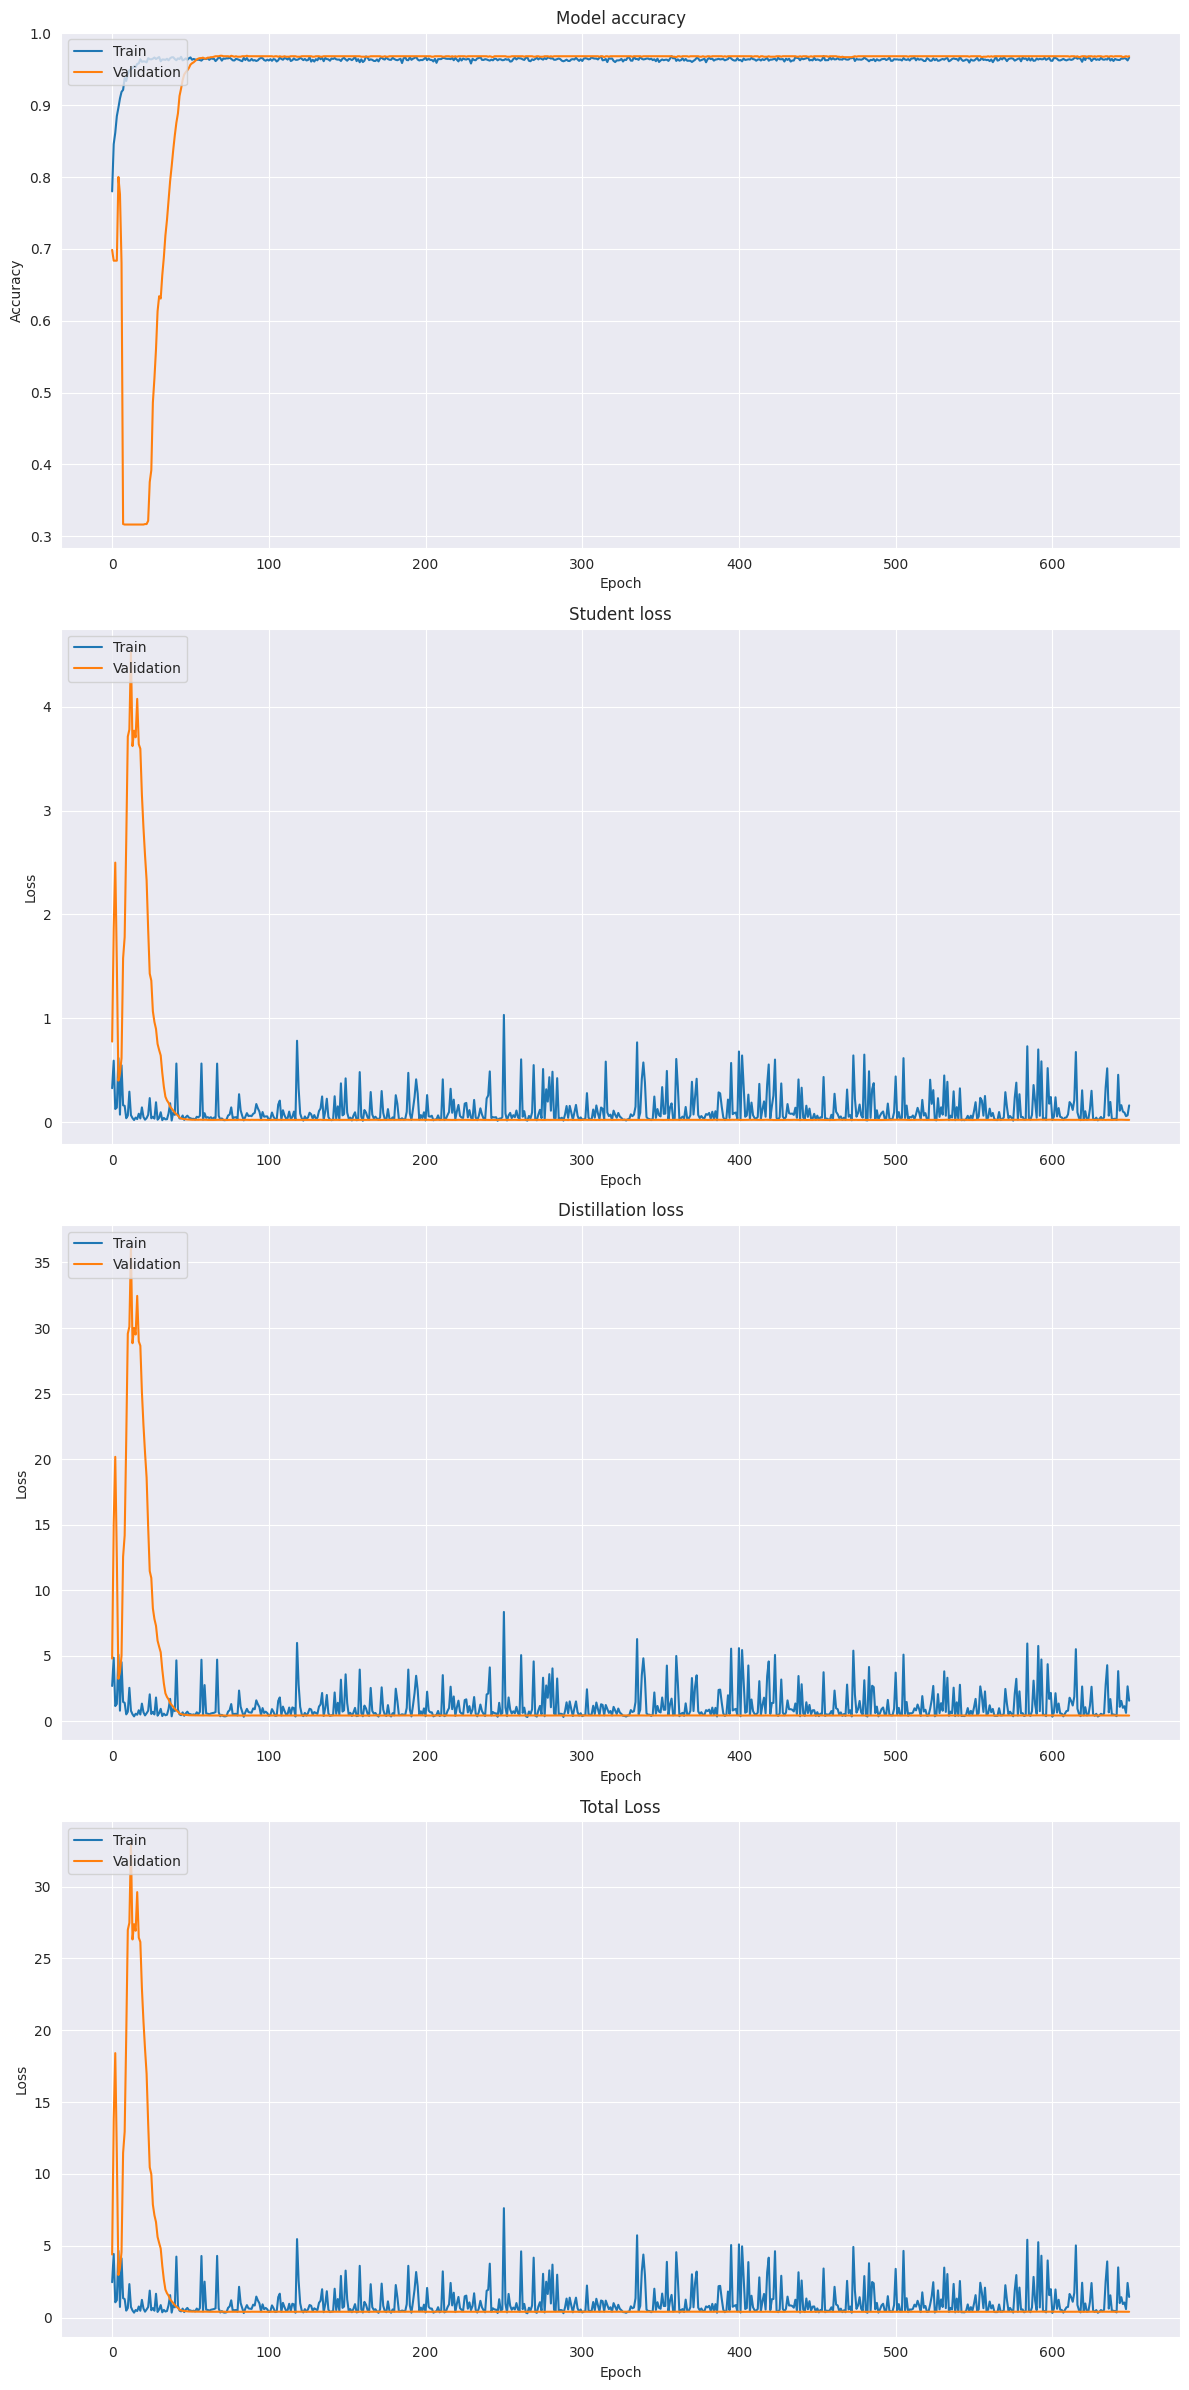

In [23]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 24))  # Adjust the figure size to be taller
    plt.subplot(4, 1, 1)  # Change the layout to 4x1
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation student loss values
    plt.subplot(4, 1, 2)
    plt.plot(history.history['student_loss'])
    plt.plot(history.history['val_student_loss'])
    plt.title('Student loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation distillation loss values
    plt.subplot(4, 1, 3)
    plt.plot(history.history['distillation_loss'])
    plt.plot(history.history['val_distillation_loss'])
    plt.title('Distillation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation total loss values
    plt.subplot(4, 1, 4)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Total Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

plot_history(history)  

In [24]:
# student.load_weights('best_model_weights.h5')

2023-09-24 06:41:32.089905: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-09-24 06:41:32.233553: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


25/25 [==============================] - 9s 24ms/step


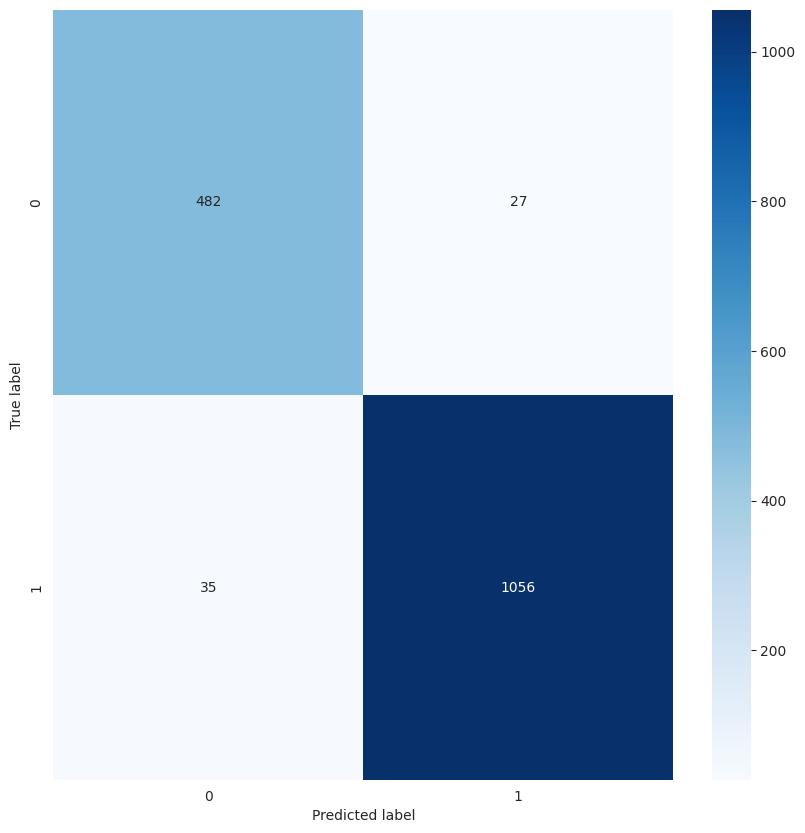

Accuracy: 96.125%
              precision    recall  f1-score   support

         hem       0.93      0.95      0.94       509
         all       0.98      0.97      0.97      1091

    accuracy                           0.96      1600
   macro avg       0.95      0.96      0.96      1600
weighted avg       0.96      0.96      0.96      1600



In [25]:
# Generate predictions
preds = distiller.student.predict(test_ds)

# Convert predictions to labels
pred_labels = (preds > 0.5).astype(np.int)

# Extract actual labels
actual_labels = tf.concat([y for x, y in test_ds], axis=0).numpy()

classes = ['hem', 'all']  # Replace with your classes

# Print confusion matrix
cm = confusion_matrix(actual_labels, pred_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Print accuracy
accuracy = accuracy_score(actual_labels, pred_labels)
print(f'Accuracy: {accuracy*100}%')

# Print classification report
report = classification_report(actual_labels, pred_labels, target_names=classes)
print(report)